## CNN 학습 구현 - MNIST

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

#### util functions

In [2]:
def im2col(input_data, filter_h, filter_w, stride = 1, pad = 0):
    N, C, H, W = input_data.shape
    
    out_h = (H +2*pad - filter_h) // stride + 1
    out_w = (W +2*pad - filter_w) // stride + 1
    
    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
            
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride = 1 , pad = 0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W + 2*pad - filter_w) // stride + 1
    
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2)
    
    img = np.zeros((N, C, H + 2*pad + stride -1, W + 2 * pad + stride - 1))
    
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
            
    return img[:, :, pad:H+pad, pad:W+pad]

def softmax(x):
    if x.ndim == 2:
        x=x.T
        x= x- np.max(x,axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(pred_y, true_y):
    return 0.5 * np.sum((pred_y - true_y)**2)

def cross_entropy_error(pred_y, true_y):
    if pred_y.ndim ==1:
        true_y = true_y.reshape(1, true_y.size)
        pred_y = pred_y.reshape(1, pred_y.size)
    
    if true_y.size == pred_y.size:
        true_y = true_y.argmax(axis=1)
        
    batch_size = pred_y.shape[0]
    return -np.sum(np.log(pred_y[np.arange(batch_size), true_y] + 1e-7)) / batch_size

def softmax_loss(X, true_y):
    pred_y = softmax(X)
    return cross_entropy_error(pred_y,true_y)

#### Utill Classes

In [3]:
class Conv2D:
    def __init__(self,W,b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        self.input_data = None
        self.col = None
        self.col_W = None
        
        self.dW = None
        self.db= None
        
    def forward(self, input_data):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = input_data.shape
        
        out_h = (H + 2 * self.pad - FH) // self.stride + 1
        out_w = (W + 2 * self.pad - FW) // self.stride + 1
        
        col = im2col(input_data,FH,FW,self.stride,self.pad)
        col_W = self.W.reshape(FN,-1).T
        
        out = np.dot(col, col_W)+ self.b
        output = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.input_data = input_data
        self.col = col
        self.col_W = col_W
        
        return output
    
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1,FN)
        
        self.db = np.sum(dout, axis= 0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.input_data.shape,FH,FW,self.stride, self.pad)
        
        return dx

In [4]:
class Pooling2D:
    def __init__(self, kernel_size=2, stride=1, pad =0):
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        
        self.input_data = None
        self.arg_max = None
        
    def forward(self, input_data):
        N, C, H, W =input_data.shape
        out_h = (H - self.kernel_size) // self.stride + 1
        out_w = (W - self.kernel_size) // self.stride + 1
        
        col = im2col(input_data, self.kernel_size, self.kernel_size, self.stride, self.pad)
        col = col.reshape(-1, self.kernel_size * self.kernel_size)
        
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        output = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)
        
        self.input_data = input_data
        self.arg_max = arg_max
        
        return output
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.kernel_size * self.kernel_size
        dmax = np.zeros((dout.size,pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] =dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.input_data.shape, self.kernel_size, self.kernel_size, self.stride, self.pad)
        
        return dx
    

In [5]:
class ReLU:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx
    
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        
        return out
    
    def backword(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx
    
class Layer:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.input_data = None
        self.input_data_shape = None
        
        self.dW = None
        self.db = None
        
    def forward(self, input_data):
        self.input_data_shape = input_data.shape
        input_data = input_data.reshape(input_data.shape[0],-1)
        self.input_data = input_data
        
        out = np.dot(self.input_data, self.W) + self.b
        
        return out
    #err
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.input_data.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.input_data_shape)
        
        return dx
    
class Softmax:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
        
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [6]:
class SGD:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.learning_rate * grads[key]

#### 데이터 로드

In [7]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()
num_classes = 10

In [8]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [9]:
x_train, x_test = np.expand_dims(x_train, axis=1),np.expand_dims(x_test, axis=1)
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


In [10]:
x_train = x_train[:3000]
x_test = x_test[:500]
t_train = t_train[:3000]
t_test = t_test[:500]
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(3000, 1, 28, 28)
(3000,)
(500, 1, 28, 28)
(500,)


#### Build Model

In [18]:
class Mymodel:
    def __init__(self, input_dim=(1, 28, 28), num_outputs=10):
        conv1_block = {'num_filters' : 30,
                       'kernel_size' : 3,
                       'stride' : 1,
                       'pad' : 0}
        input_size = input_dim[1]
        conv_output_size = ((input_size - conv1_block['kernel_size'] + 2*conv1_block['pad']) // conv1_block['stride']) + 1
        pool_output_size = int(conv1_block['num_filters'] * (conv_output_size/2) * (conv_output_size/2))
        
        self.params = {}
        self.params['W1'], self.params['b1'] = self.__init_weights_conv(conv1_block['num_filters'], input_dim[0], 3)
        self.params['W2'], self.params['b2'] = self.__init_weights_fc(pool_output_size, 256)
        self.params['W3'], self.params['b3'] = self.__init_weights_fc(256, 10)
        
        self.layers = OrderedDict()
        self.layers['Conv1'] = Conv2D(self.params['W1'], self.params['b1'])
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = Pooling2D(kernel_size=2, stride=2)
        self.layers['FC1'] = Layer(self.params['W2'], self.params['b2'])
        self.layers['ReLU'] = ReLU()
        self.layers['FC2'] = Layer(self.params['W3'], self.params['b3'])
        self.last_layer = Softmax()
        
    def __init_weights_conv(self, num_filters, data_dim, kernel_size, stride=2, pad=0,weight_std=0.01):
        weights = weight_std * np.random.randn(num_filters, data_dim, kernel_size, kernel_size)
        biases = np.zeros(num_filters)
        return weights, biases
    
    def __init_weights_fc(self, num_inputs, num_outputs, weight_std=0.01):
        weights = weight_std * np.random.randn(num_inputs, num_outputs)
        biases = np.zeros(num_outputs)
        return weights, biases
    
    def forward(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, true_y):
        pred_y = self.forward(x)
        return self.last_layer.forward(pred_y, true_y)
    
    def accuracy(self, x, true_y, batch_size=100):
        if true_y.ndim != 1:
            true_y = np.argmax(true_y, axis=1)
            
        accuracy = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = true_y[i*batch_size:(i+1)*batch_size]
            y = self.forward(tx)
            y = np.argmax(y, axis=1)
            accuracy += np.sum(y == tt)
            
        return accuracy / x.shape[0]
        
    def gradient(self, x, true_y):
        self.loss(x, true_y)
        
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads={}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['FC1'].dW, self.layers['FC1'].db
        grads['W3'], grads['b3'] = self.layers['FC2'].dW, self.layers['FC2'].db
        
        return grads
            

#### Hyper Parameters

In [19]:
epocks = 10 
train_size = x_train.shape[0]
batch_size = 200
learning_rate = 0.001
current_iter = 0

iter_per_epock = max(train_size // batch_size,1)


In [20]:
train_loss_list = []
train_acc_list = []
test_acc_list = []


In [21]:
model = Mymodel()
model.params.keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])

In [22]:
optimizer = SGD(learning_rate)

In [23]:
for epoch in range(epocks):
    for i in range(iter_per_epock):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
        
        grads = model.gradient(x_batch, t_batch)
        optimizer.update(model.params, grads)
        
        loss = model.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        
        x_train_sample, t_train_sample = x_train, t_train
        x_test_sample, t_test_sample = x_test, t_test
        
        train_acc = model.accuracy(x_train_sample, t_train_sample)
        test_acc = model.accuracy(x_test_sample, t_test_sample)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        current_iter += 1
        
    print ("Epoch: {} Train loss: {:.4f} Train Accuracy: {:.4f} Test Accuracy: {:.4f}".format(epoch+1, loss, train_acc, test_acc))

Epoch: 1 Train loss: 2.0851 Train Accuracy: 0.4307 Test Accuracy: 0.3940
Epoch: 2 Train loss: 1.5460 Train Accuracy: 0.6710 Test Accuracy: 0.5820
Epoch: 3 Train loss: 0.9737 Train Accuracy: 0.7863 Test Accuracy: 0.7240
Epoch: 4 Train loss: 0.6024 Train Accuracy: 0.8390 Test Accuracy: 0.7800
Epoch: 5 Train loss: 0.5464 Train Accuracy: 0.8637 Test Accuracy: 0.8280
Epoch: 6 Train loss: 0.3532 Train Accuracy: 0.8793 Test Accuracy: 0.8440
Epoch: 7 Train loss: 0.3205 Train Accuracy: 0.8880 Test Accuracy: 0.8560
Epoch: 8 Train loss: 0.2831 Train Accuracy: 0.8920 Test Accuracy: 0.8640
Epoch: 9 Train loss: 0.3686 Train Accuracy: 0.9010 Test Accuracy: 0.8940
Epoch: 10 Train loss: 0.3008 Train Accuracy: 0.8933 Test Accuracy: 0.8620


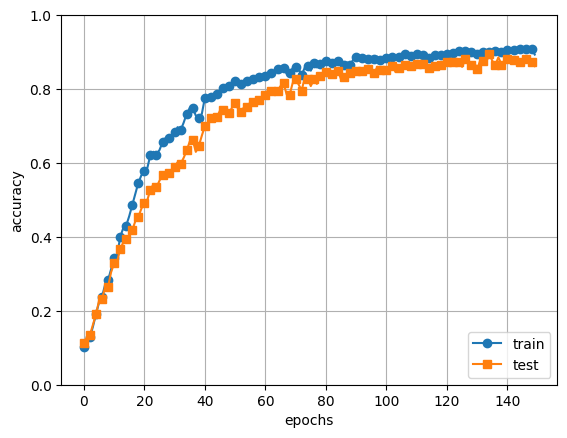

In [28]:
x = np.arange(current_iter)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=2)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

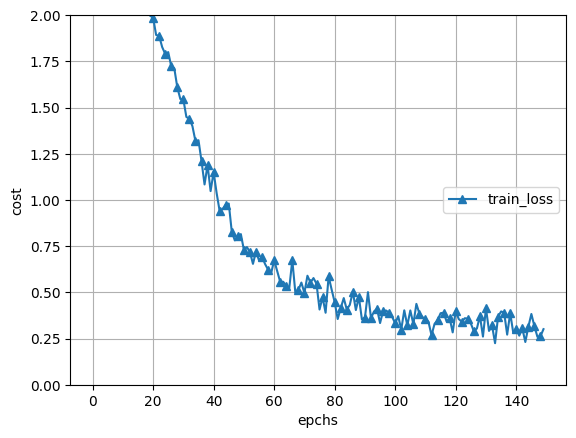

In [29]:
x = np.arange(current_iter)
plt.plot(x, train_loss_list, marker='^', label='train_loss', markevery=2)
plt.grid()
plt.xlabel('epchs')
plt.ylabel('cost')
plt.ylim(0, 2.0)
plt.legend(loc='right')
plt.show()



#### 생각보다 학습이 잘 되지 않았던 이유
- 학습데이터의 수 부족
    - 학습 시간 고려해서 데이터 양을 줄였기 때문 60000>>3000
- FC Layer의 노드수가 적절했는지
- 학습률(learning rate)값이 적절했는지
- 등등
#### 어떤 조건에서 가장 좋은 결과를 내는지 는 값을 적절히 바꾸어 시도해봐야함